In [40]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score,accuracy_score,confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from scikitplot.metrics import plot_cumulative_gain,plot_precision_recall,plot_roc,plot_ks_statistic,plot_lift_curve
import shap
import optuna
import random
import copy

In [29]:
dataset = pd.read_feather('final_dataset.feather')
dataset = dataset[dataset['LOS'].notna()]
dataset = dataset.drop(columns=['PATIENT_CLASS_GROUP_encoded','ICU_ADMIN_FLAG_encoded'])
print(len(dataset.columns))

105


In [37]:
dataset.shape

(57941, 106)

<Axes: >

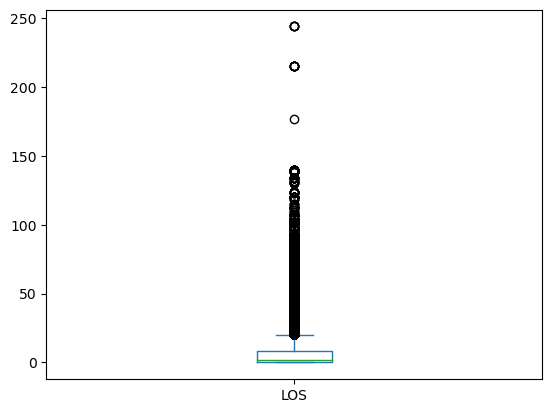

In [30]:
dataset['LOS'].plot(kind='box')

Categorizing the Length of Stay into 2 categories. 
1. Length of Stay within 1 day
2. Length of Stay more than or equal to 1 day

In [31]:
dataset['LOS_cat'] = dataset['LOS'] > 1
dataset['LOS_cat'] = dataset['LOS_cat'].astype(float)
dataset['LOS_cat'].unique()

array([0., 1.])

In [32]:
dataset['LOS_cat'].value_counts(dropna=False,normalize=True)

1.0    0.580021
0.0    0.419979
Name: LOS_cat, dtype: float64

Roughly 42% of the patient visit has been within a day

In [22]:
mrn_value_counts = dataset['MRN'].value_counts(normalize=True).reset_index()

In [23]:
mrn_value_counts = mrn_value_counts.rename(columns={'index': 'MRN', 'MRN': 'Proportion'})
mrn_value_counts.head()

,MRN,Proportion
0,1bb09d5761661c7d,0.000656
1,cd955ec437f44536,0.000552
2,b36a44c0b49c1226,0.000449
3,e43f3b4bcb161d8a,0.000449
4,c61f255b8b424eac,0.000431


mrn_value_counts is a dataframe showing the proportion of visits of each patients.

In [34]:
mrn_dict = {}
for k,v in zip(mrn_value_counts['MRN'],mrn_value_counts['Proportion']):
    mrn_dict[k] = v
#mrn_dict

We are splitting the Data as given below:
1. Train Data 75%
2. Test Data 15%
3. Validation Data 10%

Train and Test Data is given to train the model and check accuracy.
Validation data is the final test data for which we run final round of testing.

In [38]:

def split_data(dataset,mrn_dict,size=0.2):
    mrn_copy = list(dataset['MRN'].unique()) #get copy of unique MRN values in the dataset
    prop = 0 #track the cumulative proportion of selected MRNs for the testing set.
    test_id = [] #list to store the selected MRN values for the testing set.
    while prop <= size: #loop until prop reaches the size of test data
        rand_mrn = mrn_copy[random.randint(0,len(mrn_copy)-1)]
        test_id.append(rand_mrn)
        mrn_copy.remove(rand_mrn)
        prop += mrn_dict[rand_mrn]
    
    test_data  = dataset[dataset['MRN'].isin(test_id)]
    train_data  = dataset[~dataset['MRN'].isin(test_id)]
    #print(test_data.shape,train_data.shape)
    return test_data,train_data

        

In [36]:
test_data,train_data = split_data(dataset,mrn_dict,size=0.15)
val_data,train_data = split_data(train_data,mrn_dict,size=0.1)
print(train_data.shape,test_data.shape,val_data.shape)


(43454, 106) (8692, 106) (5795, 106)


In [12]:
dataset['MRN'].nunique()

38124

In [39]:
#check if there is any MRN that is overlapping across test,train and validation datasets
print(set(train_data['MRN']).intersection(set(test_data['MRN'])))
print(set(train_data['MRN']).intersection(set(val_data['MRN'])))
print(set(test_data['MRN']).intersection(set(val_data['MRN'])))
len(set(train_data['MRN'])) + len(set(test_data['MRN'])) + len(set(val_data['MRN']))

set()
set()
set()


38124

In [42]:
y_train = train_data.pop('LOS_cat')
y_val = val_data.pop('LOS_cat')
y_test = test_data.pop('LOS_cat')
train_data = train_data.drop(columns=['MRN','LOG_ID','LOS'])
val_data = val_data.drop(columns=['MRN','LOG_ID','LOS'])
test_data = test_data.drop(columns=['MRN','LOG_ID','LOS'])
print(y_train.shape,y_val.shape,y_test.shape)

(43454,) (5795,) (8692,)


In [41]:
cat_columns = [0,1,2]

In [44]:

t_data = lgb.Dataset(train_data, label=y_train)
v_data = lgb.Dataset(val_data, label=y_val)


def objective(trial):
    # Define hyperparameters to be tuned using Optuna
    params = {
        "objective": "binary",
        "metric": "auc",
        "early_stopping_round" : 50,
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "verbosity": -1,
        "num_leaves": trial.suggest_int("num_leaves", 2, 2**10),
        "max_depth" : trial.suggest_int("max_depth", 2, 2**5),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
        'cat_smooth' : trial.suggest_int('min_data_per_groups', 1, 100)
    }

    # Perform cross-validation using LightGBM
    cv_results = lgb.cv(
        params,
        t_data,
        nfold=5,
        stratified=False,
        categorical_feature = cat_columns,
        metrics=['auc'],
        eval_train_metric=True
    )

    # Find the best round (number of iterations) from cross-validation results
    best_round = len(cv_results["train auc-mean"])
    
    # Copy the hyperparameters and set the number of estimators to the best round
    params_copy = copy.deepcopy(params)
    params_copy['n_estimators'] = best_round
    
    # Train the LightGBM model on the training data
    model = lgb.train(params_copy, t_data, categorical_feature=cat_columns, valid_sets=[v_data])
    
    # Make predictions on the validation set
    predictions = model.predict(val_data)
    
    # Calculate AUC score for the validation set
    auc = roc_auc_score(y_val, predictions)
    
    # Set the best number of estimators as a user attribute for tracking
    trial.set_user_attr("n_estimators", best_round)
    
    # Return the AUC score as the objective function value
    return auc


In [ ]:
# Create an Optuna study with the objective function to maximize AUC score
study = optuna.create_study(direction='maximize')
# Perform optimization using Optuna with a specified number of trials (iterations)
study.optimize(objective, n_trials=30)

[I 2024-01-03 23:16:23,528] A new study created in memory with name: no-name-553de78f-0170-4d0b-8e93-10667c6a37a9
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Found 'n_estimators' in params. Will use it instead of 'num_boost_round' argument


In [ ]:
params = study.best_trial.params
params['n_estimators'] = study.best_trial.user_attrs['n_estimators']
model = lgb.train(params, t_data,categorical_feature=cat_columns,valid_sets=[v_data])


In [23]:
def get_performance(model,data,true):
    preds = model.predict(data)
    preds_for_acc = (preds > 0.5).astype(float)
    preds_df = pd.DataFrame(preds,columns=['1'])
    preds_df['0'] =  1 -  preds_df['1']
    preds_df = preds_df[['0','1']].values
    
    auc  = roc_auc_score(true,preds)
    tn, fp, fn, tp = confusion_matrix(true,preds_for_acc).ravel()

    conf_matrix = confusion_matrix(true,preds_for_acc)
    
    accuracy = accuracy_score(true, preds_for_acc)
    sens = tp/(tp+fn)
    spec = tn/(tn+fp)

    fig,ax = plt.subplots()
    plot_roc(true,preds_df,ax=ax)

    fig,ax = plt.subplots()
    plot_cumulative_gain(true,preds_df,ax=ax)

    fig,ax = plt.subplots()
    plot_precision_recall(true,preds_df,ax=ax)

    fig,ax = plt.subplots()
    plot_lift_curve(true,preds_df,ax=ax)

    fig,ax = plt.subplots()
    plot_ks_statistic(true,preds_df,ax=ax)

    fig,ax = plt.subplots()
    sns.heatmap(conf_matrix, annot=True, fmt='d', ax=ax)
    # set x-axis label and ticks. 
    ax.set_xlabel("Predicted Label", fontsize=14, labelpad=20)
    ax.xaxis.set_ticklabels(['LOS <=1', 'LOS > 1'])

    # set y-axis label and ticks
    ax.set_ylabel("Actual Label", fontsize=14, labelpad=20)
    ax.yaxis.set_ticklabels(['LOS <=1', 'LOS > 1'])

    # set plot title
    ax.set_title("Confusion Matrix for LOS Prediction Model", fontsize=14, pad=20)



    result = {
        'auc' : auc,
        'sensitivity': sens,
        'specificity' : spec,
        'accuracy' : accuracy,
    }
    fig,ax = plt.subplots()
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(data)
    shap.summary_plot(shap_values, data)
   

    return preds,result


In [24]:
y_val.mean(),y_train.mean(),y_test.mean()

(0.5807453416149069, 0.5796147561733367, 0.5815692590888173)

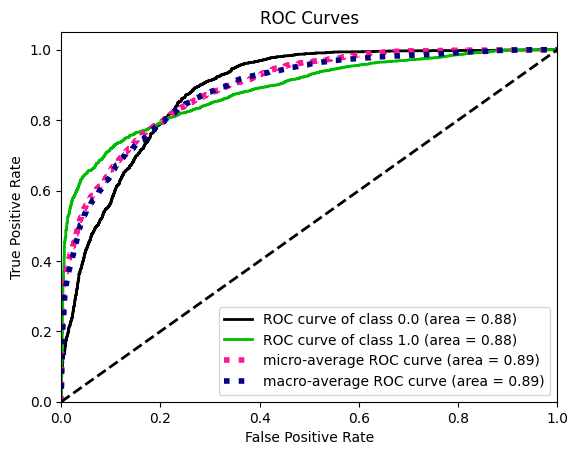

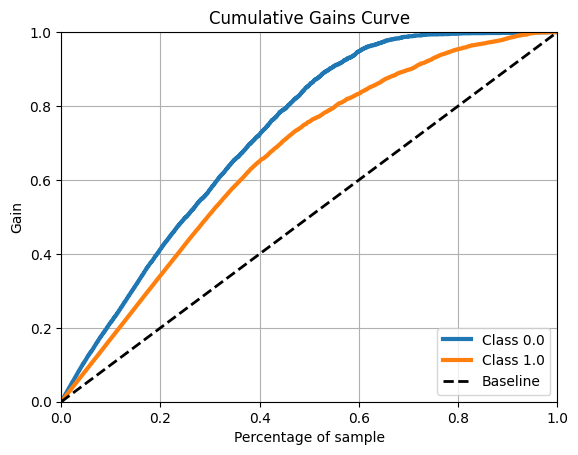

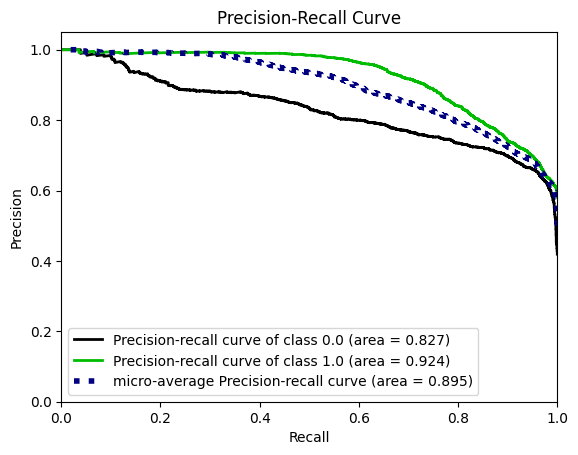

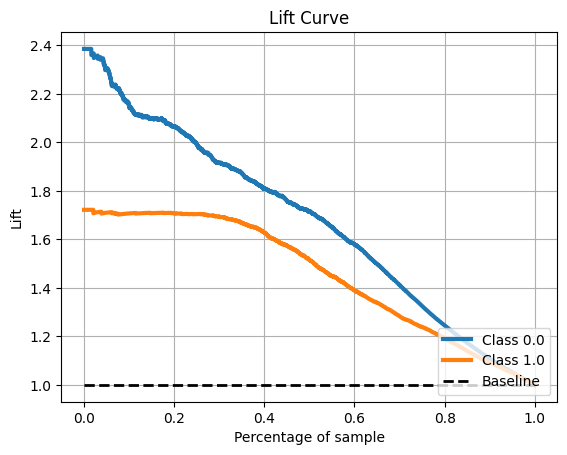

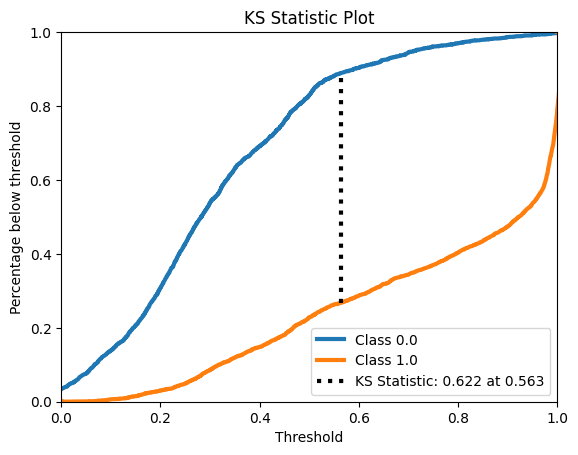

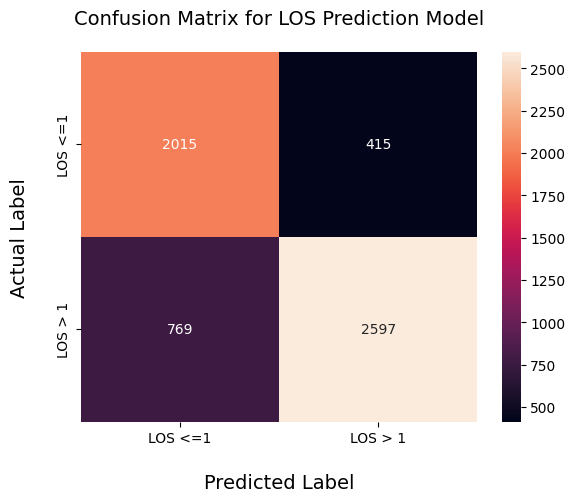

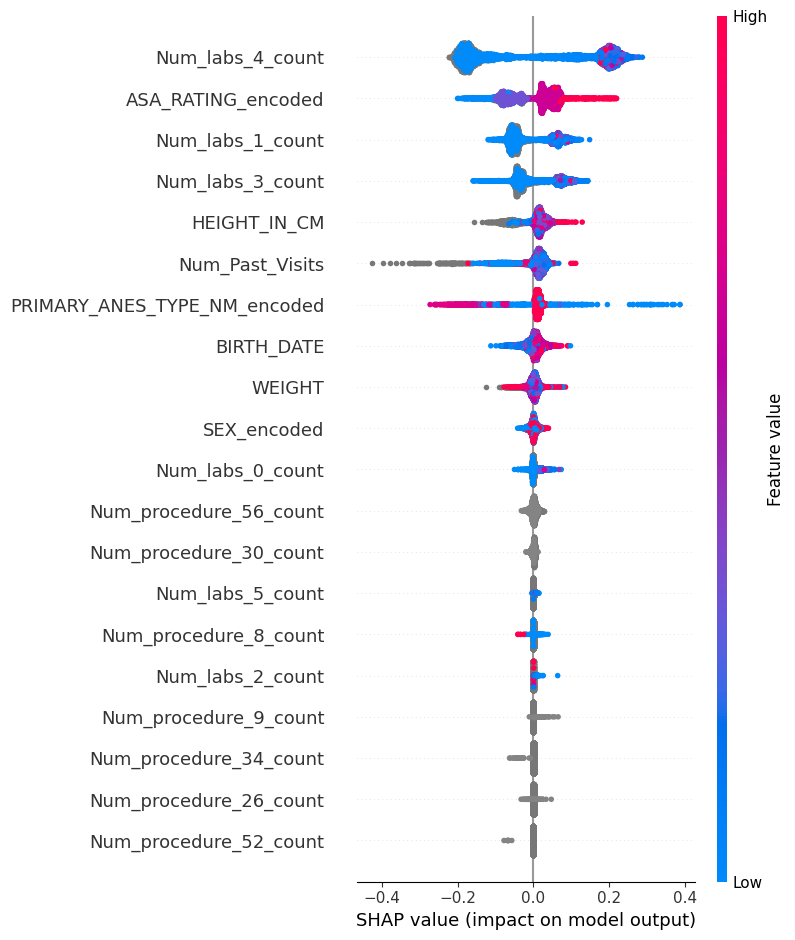

In [25]:
val_pred,val_performance = get_performance(model,val_data,y_val)

In [26]:
val_performance

{'auc': 0.8849198227738533,
 'sensitivity': 0.7715389185977422,
 'specificity': 0.8292181069958847,
 'accuracy': 0.7957211870255348}

In [27]:
feat_imp_df = pd.DataFrame()
feat_imp_df['Feature_Importance'] = model.feature_importance(importance_type='gain')
feat_imp_df['Feature_Name'] = list(train_data.columns)
feat_imp_df = feat_imp_df.sort_values(by='Feature_Importance',ascending=False)

In [ ]:
feat_imp_df.head()

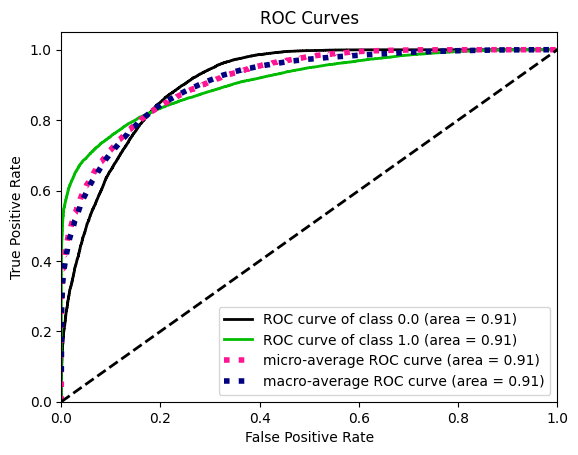

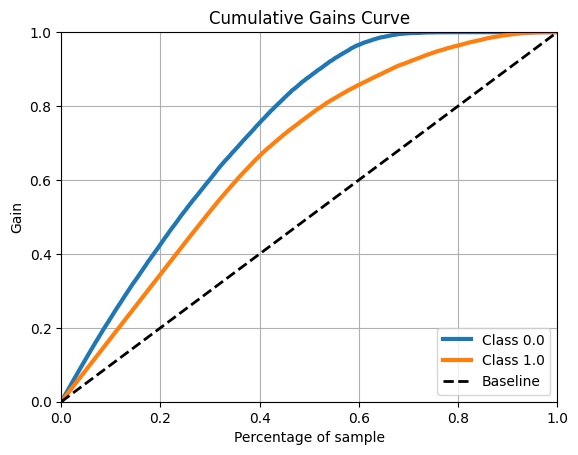

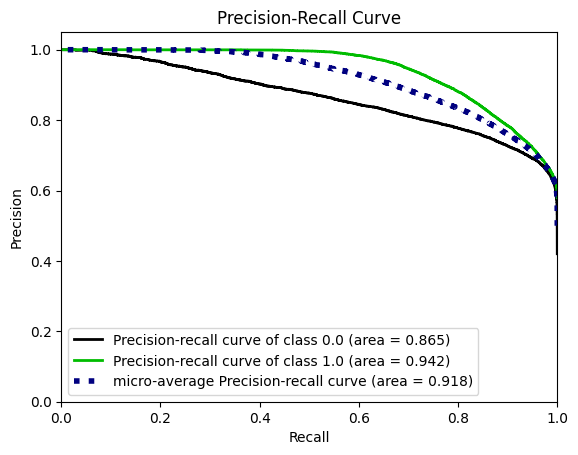

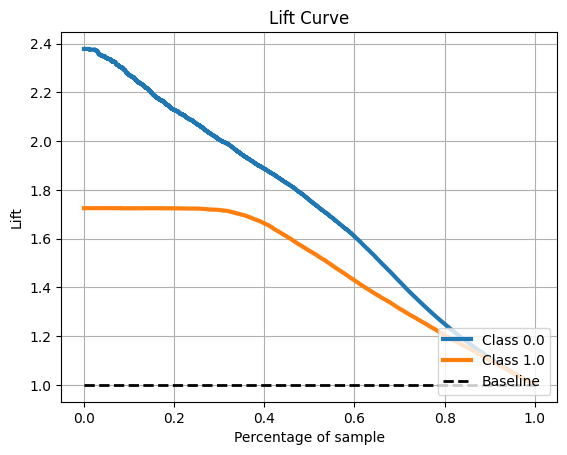

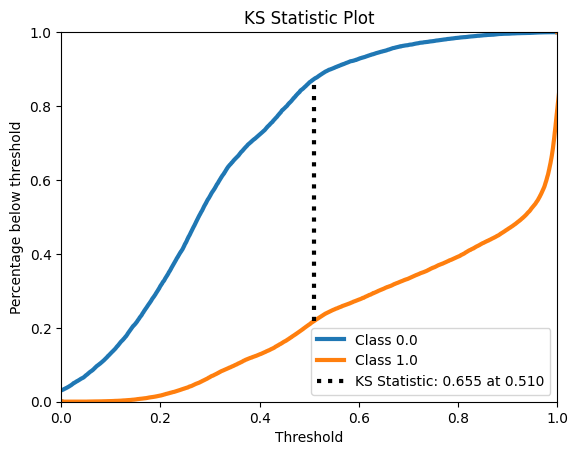

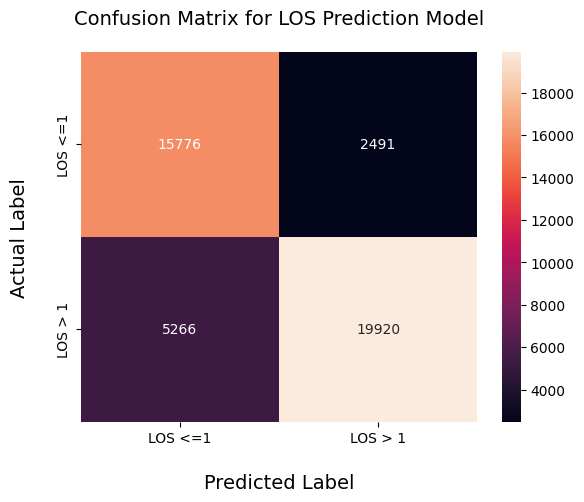

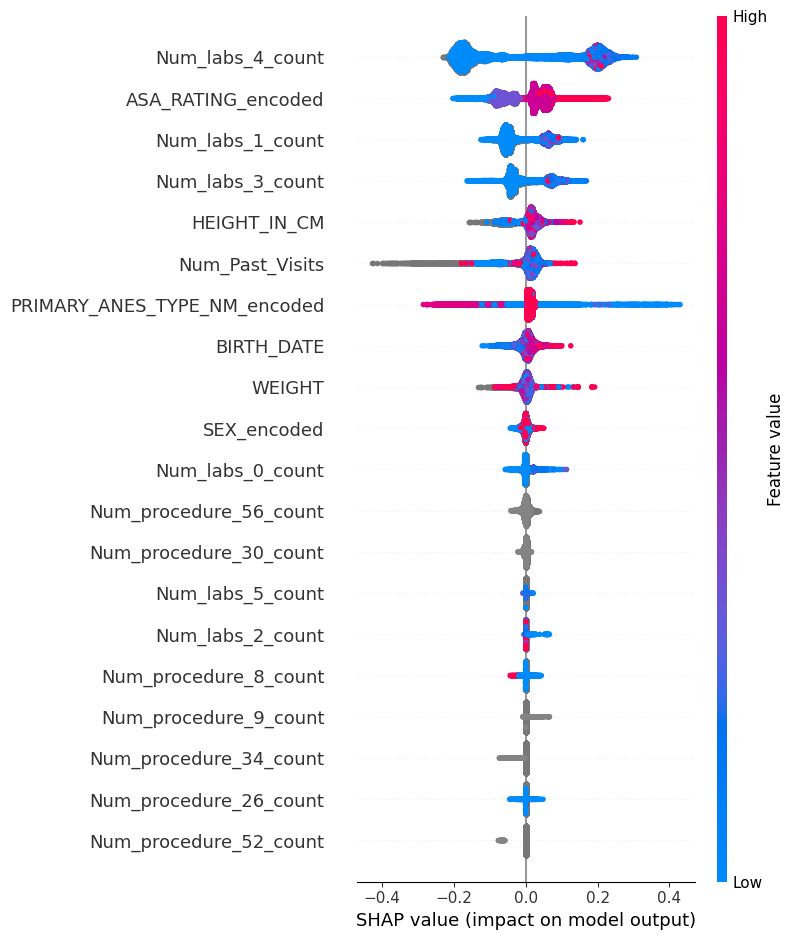

{'auc': 0.9093581135233808, 'sensitivity': 0.7909155880250933, 'specificity': 0.8636338752942464, 'accuracy': 0.8214852829493936}


In [29]:
train_pred,train_performance = get_performance(model,train_data,y_train)
print(train_performance)

In [30]:
train_performance

{'auc': 0.9093581135233808,
 'sensitivity': 0.7909155880250933,
 'specificity': 0.8636338752942464,
 'accuracy': 0.8214852829493936}

In [1]:
test_pred,test_performance = get_performance(model,test_data,y_test)
print(test_performance)

NameError: name 'get_performance' is not defined